In [163]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [149]:
df = pd.read_csv("~/Desktop/Codes/house_prediction/Bengaluru_House_Data.csv")

In [150]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [151]:
df.dtypes

area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object

In [152]:
df.shape

(13320, 9)

In [153]:
df1['location'].value_counts()

location
Whitefield         397
Sarjapur  Road     310
Electronic City    236
Kanakpura Road     216
Thanisandra        212
                  ... 
Adarsh Nagar         1
S R Layout           1
Sadduguntepalya      1
BCC Layout           1
Abshot Layout        1
Name: count, Length: 634, dtype: int64

In [154]:
#One hot encoding to check if the "area_type" column has any effect on the price of the house

#Specifying the categorical column
categorical_column = ['area_type']

#Creating the OneHotEncoder object
onehot_encoder = OneHotEncoder(sparse_output = False)

#Fitting the encoder to the data and transforming the data
encoded_data = onehot_encoder.fit_transform(df[categorical_column])

#Creating a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns = onehot_encoder.get_feature_names_out(categorical_column))

#Concatenating the original DataFrame with the encoded DataFrame
final_encoded_df = pd.concat([df, encoded_df], axis = 1).drop(categorical_column, axis = 1)

#Printing the final DataFrame
final_encoded_df.head()

,availability,location,size,society,total_sqft,bath,balcony,price,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,0.0,0.0,0.0,1.0
1,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,0.0,0.0,1.0,0.0
2,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,1.0,0.0,0.0,0.0
3,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,0.0,0.0,0.0,1.0
4,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,0.0,0.0,0.0,1.0


In [155]:
final_encoded_df.dtypes

availability                       object
location                           object
size                               object
society                            object
total_sqft                         object
bath                              float64
balcony                           float64
price                             float64
area_type_Built-up  Area          float64
area_type_Carpet  Area            float64
area_type_Plot  Area              float64
area_type_Super built-up  Area    float64
dtype: object

In [156]:
#Changing the data type of the 'total_sqft' column to numeric
final_encoded_df['total_sqft'] = pd.to_numeric(final_encoded_df['total_sqft'], errors='coerce')

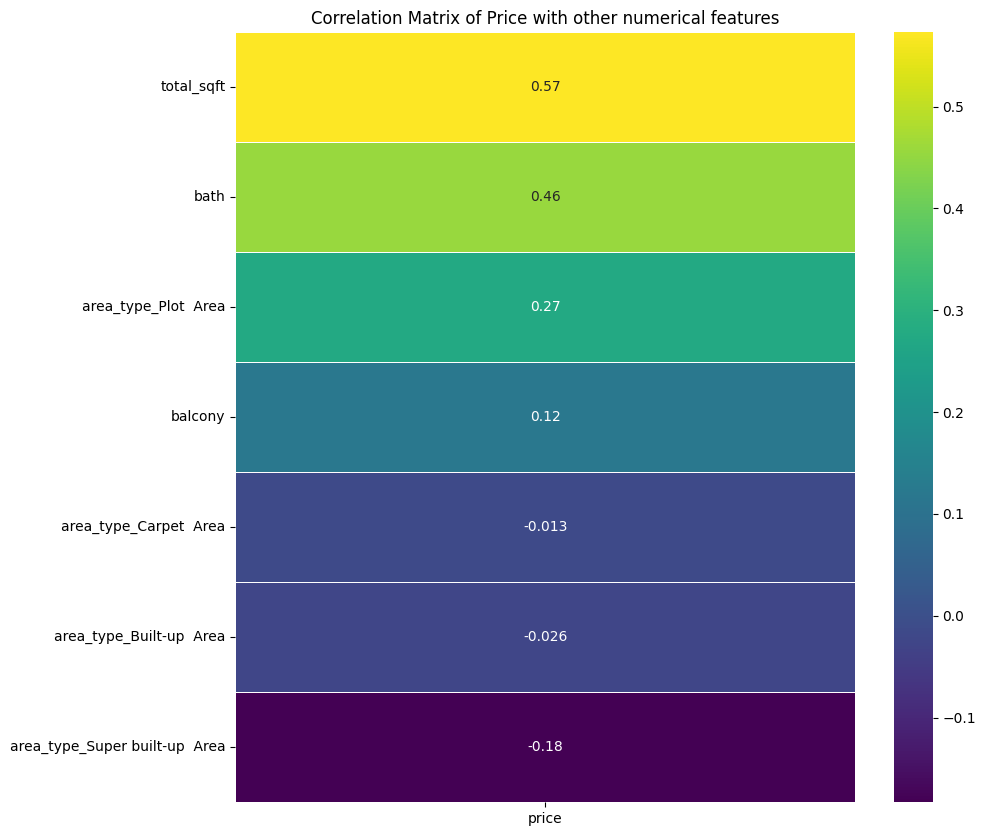

In [172]:
#Computing the correlation matrix
correlation_matrix = final_encoded_df.corr(numeric_only=True)

# Sort features by correlation with 'price' (descending order)
sorted_corr = correlation_matrix['price'].sort_values(ascending=False)

# Remove 'price' from the sorted_corr index
sorted_corr = sorted_corr.drop('price')

#Plotting the heat map
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix.loc[sorted_corr.index, ['price']], annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Price with other numerical features')
plt.show()

In [158]:
#Dropping unnecessary columns that are not relevant to the analysis
df2 = final_encoded_df.drop(['availability', 'society', 'balcony', 'area_type_Built-up  Area', 'area_type_Carpet  Area', 'area_type_Plot  Area', 'area_type_Super built-up  Area'], axis='columns')

In [159]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00
2,Uttarahalli,3 BHK,1440.0,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00
4,Kothanur,2 BHK,1200.0,2.0,51.00


In [160]:
df2.dropna(inplace=True)

In [161]:
df2.shape

(13056, 5)